<a href="https://colab.research.google.com/github/lilian95520/ML-Predicting-university-student-performance/blob/main/Projet_ML_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Project** - Laura Aboukrat, Laura Deleuze, Lilian Allio

---



# Introduction

**Our goal : Predicting university student performance**

This project aims to predict students final grades (A, B or C) based on demographic, academic, social and lifestyle factors.

Using machine learning, the goal is to identify which variables strongly influence academic success. By building a predictive model, we can detect students at risk of low performance early and provide targeted academic or psychological support. This analysis can help universities design personalized learning strategies and improve student outcomes.

In [3]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_regression

# Descriptive analysis

### Dataset loading

In [4]:
df = pd.read_csv("Student_performance_data _.csv")
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


### Creation of GradeClass

The initial column **GradeClass** was created by the owner of the dataset based on the GPA score. Five grade categories were defined: A, B, C, D, and E. We decided to rebuild this variable because the dataset contains only 2392 observations and keeping five separate classes would lead to:
- Highly imbalanced categories, especially for A and E
- Too few samples per class, degrading model training
- Lower predictive performance due to class sparsity

To address this issue, we grouped the original five classes into three categories:
- 0: A + B : High performance
- 1: C + D : Medium performance
- 2: E : Low performance

This new version of GradeClass ensures a more balanced distribution and makes the prediction task more realistic for machine learning models given the dataset size.

In [5]:
df = df.drop(columns=['GradeClass', 'StudentID']) #we drop StduentID because it's useless
df.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061


In [6]:
def map_grade(gpa):
    if gpa>=3.0:         #A
        return 0
    elif gpa>=2.0:       #B
        return 1
    else:                #C
        return 2

df['GradeClass']=df['GPA'].apply(map_grade)


### Dataset information

In [7]:
print("Shape of the dataset: ",df.shape)
print("Columns of the dataset: \n",df.columns)

Shape of the dataset:  (2392, 14)
Columns of the dataset: 
 Index(['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly',
       'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports',
       'Music', 'Volunteering', 'GPA', 'GradeClass'],
      dtype='object')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GPA                2392 non-null   float64
 13  GradeClass         2392 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 261.8 KB


In [9]:
df.isna().any()

,0
Age,False
Gender,False
Ethnicity,False
ParentalEducation,False
StudyTimeWeekly,False
Absences,False
Tutoring,False
ParentalSupport,False
Extracurricular,False
Sports,False


**The dataset contains no missing values:** all columns have complete data. This allows exploratory analysis and model preparation to be carried out without any imputation steps.

In [10]:
df.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,1.398411
std,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,0.712942
min,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,1.000000
50%,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,2.000000
75%,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,2.000000
max,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000


Descriptive statistics show that the dataset is **complete and balanced**.
- The age of students varies mainly between 15 and 18, with an average of 16.47. Weekly study time varies greatly, ranging from almost 0 to 20 hours.
- Absences are also widely dispersed, with some reaching nearly 30 days. Several variables are binary (Sports, Tutoring, Extracurricular) while others are ordinal (ParentalEducation, ParentalSupport).
- The GPA ranges from 0 to 4, with an average of around 1.9, which corresponds to a distribution generally centered on average to low performance.
- Finally, the grade class (GradeClass) is divided into three categories (0, 1, 2) after grouping.



# Exploratory analysis

In [11]:
categorical_cols = ["Gender", "Ethnicity", "ParentalEducation",
                    "Tutoring", "ParentalSupport", "Extracurricular",
                    "Sports", "Music", "Volunteering", "GradeClass"]

numerical_cols = ["Age", "StudyTimeWeekly", "Absences", "GPA"]

### Distribution of categorical features

In [12]:
#use 2 versions of df: the normal version and a text version for graphs
df_label=df.copy()

mapping_gender={
    0: "Male",
    1: "Female"
}
df_label["Gender"]=df_label["Gender"].map(mapping_gender)

mapping_ethnicity = {
    0: "Caucasian",
    1: "African American",
    2: "Asian",
    3: "Other"
}
df_label["Ethnicity"]=df_label["Ethnicity"].map(mapping_ethnicity)

mapping_parentalEducation={
    0: "None",
    1: "High School",
    2: "Some College",
    3: "Bachelor's",
    4: "Higher"
}
df_label["ParentalEducation"]=df_label["ParentalEducation"].map(mapping_parentalEducation)

mapping_tutoring={
    0: "No",
    1: "Yes"
}
df_label["Tutoring"]=df_label["Tutoring"].map(mapping_tutoring)

mapping_parentalSupport={
    0: "None",
    1: "Low",
    2: "Moderate",
    3: "High",
    4: "Very High"
}
df_label["ParentalSupport"]=df_label["ParentalSupport"].map(mapping_parentalSupport)

mapping_extracurricular={
    0: "No",
    1: "Yes"
}
df_label["Extracurricular"]=df_label["Extracurricular"].map(mapping_extracurricular)

mapping_sports={
    0: "No",
    1: "Yes"
}
df_label["Sports"]=df_label["Sports"].map(mapping_sports)

mapping_music={
    0: "No",
    1: "Yes"
}
df_label["Music"]=df_label["Music"].map(mapping_music)

mapping_volunteering={
    0: "No",
    1: "Yes"
}
df_label["Volunteering"]=df_label["Volunteering"].map(mapping_volunteering)

mapping_gradeClass={
    0: "A",
    1: "B",
    2: "C"
}
df_label["GradeClass"]=df_label["GradeClass"].map(mapping_gradeClass)

In [13]:
for col in categorical_cols:
    #Prepare the dataframe for Plotly
    temp=df_label[col].value_counts().reset_index()
    temp.columns=[col, "Count"]

    #interactive plot
    fig=px.bar(
        temp,
        x=col,
        y="Count",
        text="Count",
        title=f"Distribution of {col}",
        color=col,
        color_discrete_sequence=px.colors.qualitative.Pastel
        )
    fig.update_traces(textposition="outside")
    fig.update_layout(
        title_x=0.5,
        template="plotly_white",
        xaxis_title="",
        yaxis_title="Count",
        showlegend=False,
        font=dict(size=14))

    fig.show()




- **Gender:** The proportion of **girls** and **boys** is balanced, with no marked imbalance between the two genders

- **Ethnicity:** The majority of students belong to the **Caucasian** ethnic group

- **Parental Education:** Regarding parents' education levels, the **college** category is the most common, followed by high school diplomas, then parents with bachelor's degrees

- **Parental support:** The level of parental support is generally moderate or high

- A large proportion of students do not participate in **music**, **sports**, **tutoring** or **volunteering**

- **GradeClass:** The distribution of grade classes is clearly unbalanced: the majority of students belong to the Low category (1,274 students), while the Medium category is moderately represented (797 students). The High category is clearly in the minority, with only 321 students. This distribution indicates a dataset dominated by low performance, which will need to be taken into account during modeling, particularly to manage class imbalance.








### Distribution of numerical features

In [14]:
import plotly.express as px

for col in numerical_cols:
    fig = px.histogram(
        df_label,
        x=col,
        nbins=20,
        title=f"Distribution of {col}",
        opacity=0.85,
        color_discrete_sequence=["cornflowerblue"]
    )

    # Barres séparées + contour
    fig.update_traces(
        marker=dict(
            line=dict(width=1.2, color="white")  # contour blanc
        )
    )

    # Ajout d’espace entre les colonnes
    fig.update_layout(
        bargap=0.2,           # ← espace net entre les barres
        bargroupgap=0.1,
        template="plotly_white",
        title_x=0.5,
        font=dict(size=14),
        height=500
    )

    fig.show()


- **Age:** The sample has a homogeneous **age** distribution, ranging from 15 to 18 years old, with no group significantly over or under-represented

- **StudTimeWeekly:** Weekly study time is fairly evenly distributed between 0 and 20 hours. There is a slight concentration around 10 to 12 hours, but no category really dominates. This indicates that students adopt very varied study patterns and that there is no majority behavior

- **Absences:** The number of absences varies greatly among students, but the distribution remains relatively even overall. There is a slight peak around 10 to 15 absences, which shows that a significant proportion of students regularly miss classes

- **GPA:** The GPA distribution is centered between 1.5 and 2.5, with a maximum around 2.0. Very few students have a GPA close to 0 or 4. This bell curve suggests overall average academic performance, with few extremes


### Exploring correlations

**Correlation Matrix:**

First, we chose to start with the confusion matrix of numerical variables in order to understand the initial relationships between features.   
Thus, we look at **the link between the different variables and GPA**.

In [15]:
df_numerical = df_label[numerical_cols]
corr = df_numerical.corr()

fig = px.imshow(
    corr,
    text_auto=".2f",
    color_continuous_scale="RdBu",
    title="Correlation Matrix for numerical features"
)
fig.update_layout(title_x=0.5)
fig.show()



The correlation matrix shows that very few linear relationships exist between the numerical variables, with the exception of one particularly strong relationship.

- **Absences** has a strong negative correlation with **GPA** (-0.92):  
This means that the more a student is absent, the more their GPA decreases significantly. This is the most predictive indicator of academic performance in the dataset.

- **StudyTimeWeekly** has a weak positive correlation with **GPA** (+0.18):
Students who study more tend to perform better, but the effect is small.

- **Age** has virtually no correlation with other variables, including **GPA**:
This suggests that age does not play a significant role in performance.

The matrix highlights that absences are the most decisive variable in explaining academic success, while age and study time play a secondary or negligible role.



**Visualization of possible correlations:**

- Average Absences per Grade

In [16]:
df_mean = df_label.groupby("GradeClass", as_index=False)["Absences"].mean()

fig=px.bar(
    df_mean,
    x="GradeClass",
    y="Absences",
    title="Average Absences per Grade",
    color="Absences",
    color_continuous_scale="Viridis")
fig.update_layout(
    width=700,
    height=500,
    title_x=0.5,
    xaxis_title="Grade",
    yaxis_title="Average Absences")
fig.show()


The graph confirms what we had already noticed: a clear relationship between academic level and the average number of absences.

- **Low-level** students are by far the most absent, with an average of more than 21 absences.
This suggests a strong link between high absenteeism and poor academic performance.

- **Medium-level** students have a significantly lower average number of absences (around 9).
They are less absent than struggling students, but still far behind high-performing students.

- **High-level** students, on the other hand, are the least absent, with an average of around 3 absences.
This reinforces the idea that regular attendance contributes significantly to good results.

The graph shows that **the higher the academic level, the less absent students are**.

This is the strongest relationship in the dataset: absenteeism is a powerful indicator of academic performance.



- Average StudyTimeWeekly per Grade

In [17]:
df_mean = df_label.groupby("GradeClass", as_index=False)["StudyTimeWeekly"].mean()

fig=px.bar(
    df_mean,
    x="GradeClass",
    y="StudyTimeWeekly",
    title="Average StudyTimeWeekly per Grade",
    color="StudyTimeWeekly",
    color_continuous_scale="Viridis")
fig.update_layout(
    width=700,
    height=500,
    title_x=0.5,
    xaxis_title="Grade",
    yaxis_title="Average StudyTimeWeekly")
fig.show()

Students with a **High** grade spend on average slightly more time studying each week than those with a **Medium** or **Low** grade.  

The **Low** category studies the least, while **High** has the highest weekly study time, suggesting a **positive relationship** between study time and performance level.

- Boxplot: GPA based on ParentalSupport

In [18]:
px.box(df_label, x="ParentalSupport", y="GPA", color="ParentalSupport",
       category_orders={
        "ParentalSupport": ["Very High", "High", "Moderate", "Low", "None"]})


There is a general trend: **the higher the parental support, the higher the GPA tends to be.**
Students with **Very High** support have the highest GPA medians and a higher overall distribution, while the **Low** and **None** categories show lower medians.

This suggests that parental support plays **a positive role** in academic success.

- Boxplot: GPA based on Tutoring

In [19]:
px.box(df_label, x="Tutoring", y="GPA", color="Tutoring")

Students receiving tutoring have a **slightly higher GPA** on average, with their median score above that of students without tutoring.
However, the difference remains **moderate**, and the variability of the two groups is fairly similar.

Tutoring therefore appears to have a **positive but limited effect** on academic performance.

- Correlation Matrix (numerical+categorical features)

In [20]:
corr_matrix = df.corr()

fig = px.imshow(
    corr_matrix,
    color_continuous_scale="RdBu_r",
    text_auto=".2f",
    title="Correlation Matrix (Numerical + Categorical)"
)
fig.update_layout(width=900, height=900)
#Improved legibility of labels
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig.update_yaxes(tickfont=dict(size=10))
fig.show()


**Correlation matrix analysis**

*Principal correlations with GPA*

---

**1. Absences -> GPA : -0.92**
- Extremely strong and negative correlation
- The more classes a student misses, the more their GPA drops
- This is by far the most decisive factor

**2. StudyTimeWeekly -> GPA : +0.18**
- Positive but moderate link
- Working more helps, but it is not the most influential factor

**3. Tutoring -> GPA : +0.15**
- Positive and measurable impact
- Consistent with the box plot: tutored students perform slightly better

**4. ParentalSupport -> GPA : +0.19**
- Positive but weak influence
- Parental support helps, but is not decisive

**5. Volunteering -> GPA : +0.09**
- Minor but slightly positive effect
- May reflect more organized or responsible students

*Relationships between explanatory variables*

---

**1. StudyTimeWeekly and Absences :**-0.15
- Students who study more are slightly less absent
- Consistent but weak relationship

**2. Extracurricular, Sports, Music and GPA :** correlations close to 0
- Extracurricular activities have virtually no impact on academic performance

*Demographic variables*

---

- Age, Gender, Ethnicity : virtually no correlations

*ParentalEducation*

---

- Very weak correlations with GPA and other variables


**Conclusion:**

Most important factors:
- Absences (-0.92)
- Tutoring (+0.15)
- StudyTimeWeekly (+0.18)
- ParentalSupport (+0.19)
- Volunteering (+0.09)

**N.B:**
We cannot correctly interpret the correlations between the features and the target variable **GradeClass**, because its encoding is reversed (0=A, 1=B, 2=C).  
With this order, the model believes that 0 is the worst grade, when in fact it is the best.

Result: the correlations are skewed.
For example, the correlation between Absences and GradeClass is 0.83, which would suggest that the more a student misses classes, the better their grades are, which is obviously false.






# Pre-Processing

### Verification

We have no missing values in our dataset.

In [21]:
sum(df.duplicated())

0

There are no duplicates.

### Outliers

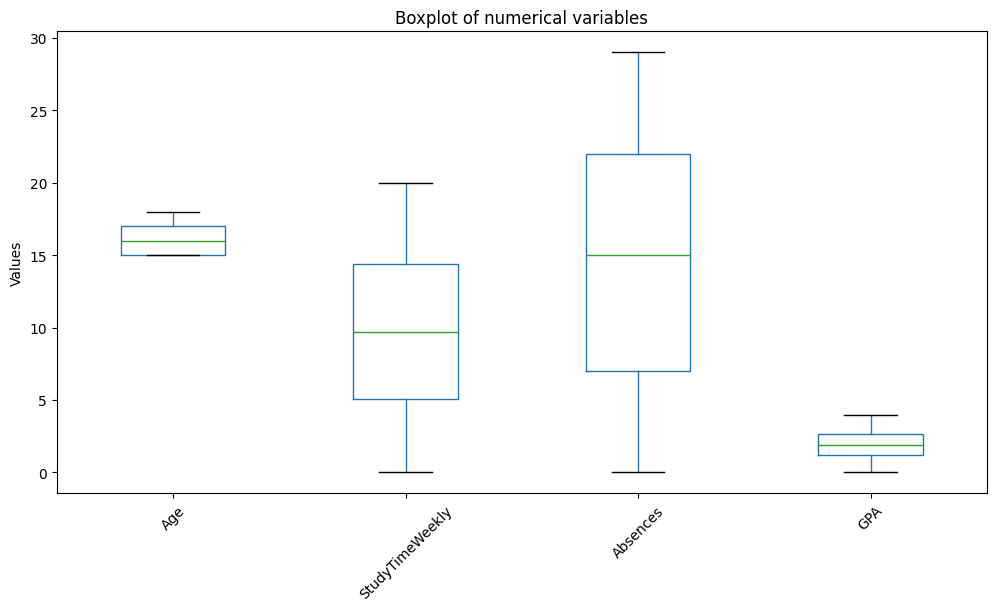

In [22]:
#Creating a box plot to detect outliers
plt.figure(figsize=(12, 6))
df[numerical_cols].boxplot()
plt.title("Boxplot of numerical variables")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

**Boxplot Analysis**

- **Age:** very narrow distribution, no outliers

- **StudyTimeWeekly:** higher variability but no marked outliers

- **Absences:** the most dispersed variable, but ranging from 0 to 29 hours, so no outliers.

- **GPA:** no outliers


### Creation of new features

In [23]:
df["AbsenceStudyRatio"]=df["Absences"]/(df["StudyTimeWeekly"]+1)

**AbsenceStudyRatio = Absences / (StudyTimeWeekl+ 1)**

**Why:**
This feature captures how costly the absences are relative to the student's weekly study time. A student who studies very little but has many absences will naturally have a high ratio, indicating a potentially risky academic profile.

It provides an interpretable scale where:
- High ratio: many absences + little studying = high risk of low performance
- Low ratio: few absences or strong study habits = more stable and motivated student

This variable helps quantify whether absences are likely to have a real impact on grades, beyond just counting them.

In [24]:
df["StudySupportInteraction"]=df["StudyTimeWeekly"]*df["ParentalSupport"]

**StudySupportInteraction=StudyTimeWeekly x ParentalSupport**

**Why:**
This feature captures the **combined effect** of personal study effort and support received at home. Individually, study time and parental support both influence performance, but their interaction can reveal deeper patterns: students who study a lot and receive strong support tend to perform significantly better.

It provides an interpretable scale where:
- High score: high study time + strong parental support, very favorable learning environment
- Low score: low study time and or weak support, higher risk of underperformance

This variable highlights whether support at home amplifies the benefits of studying.

In [25]:
df["EngagementScore"]=(
    df["StudyTimeWeekly"]
    +df["Extracurricular"]
    +df["Sports"]
    +df["Music"]
    +df["Volunteering"])

**EngagementScore = StudyTimeWeekly + Extracurricular + Sports + Music + Volunteering**

**Why:**
This variable captures the **overall engagement level** of the student, combining both academic investment and participation in activities. This reflects motivation, time management skills and involvement beyond the classroom.

- High score: student is highly active: studies regularly and participates in several activities, balanced, motivated, and engaged profile

- Low score: student shows little study time and low involvement: potential disengagement or lack of structure

This indicator helps assess how strongly a student invests in both academic and non-academic pursuits.

# Implementation of a baseline model

**Predicting *GradeClass* is a classification problem:**

The *GradeClass* variable represents a student's academic performance category, with three distinct classes: A, B, and C (0, 1, and 2). Since these are qualitative values rather than continuous numbers, the model must predict one class among several possibilities. This type of task therefore corresponds to a multi-class classification problem.

**Which models should be used?**

Several models are suitable for multi-class classification:

- **Logistic Regression:** simple, fast, and effective for establishing an initial baseline. It makes it easy to interpret the influence of variables on the probability of belonging to a class.

- **Random Forest Classifier:** a model based on a set of decision trees. It handles heterogeneous data, interactions between variables, and non-linearity very well. It is robust to overfitting and provides a **good estimate of feature importance.**

- **XGBoost/Gradient Boosting:** high-performance models for capturing complex relationships.

- **SVM:** effective when classes are easily separable. Works well in high dimensions, but can take longer to train.

- **K-Nearest Neighbors:** a simple method based on the proximity between observations. Useful for comparison, but generally less effective.





### Evaluation of the importance of features

In order to understand the importance of each variable for predicting the target **GradeClass**, we will implement an initial model with RandomForest. This will allow us to assess whether the features we have just created are actually useful for predicting student grades.

In [26]:
#separate X and y
#we also drop GPA because GradeClass is made from GPA
X=df.drop(columns=["GPA","GradeClass"])
y=df["GradeClass"]

#train-test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

#Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

#importance of variables
importances=rf.feature_importances_
features=X.columns

#we put it in a dataframe
features_importance=pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance",ascending=False)

features_importance

,Feature,Importance
5,Absences,0.393540
12,AbsenceStudyRatio,0.276905
13,StudySupportInteraction,0.064198
4,StudyTimeWeekly,0.059124
14,EngagementScore,0.056809
7,ParentalSupport,0.027872
3,ParentalEducation,0.018890
0,Age,0.018526
2,Ethnicity,0.017356
6,Tutoring,0.016896


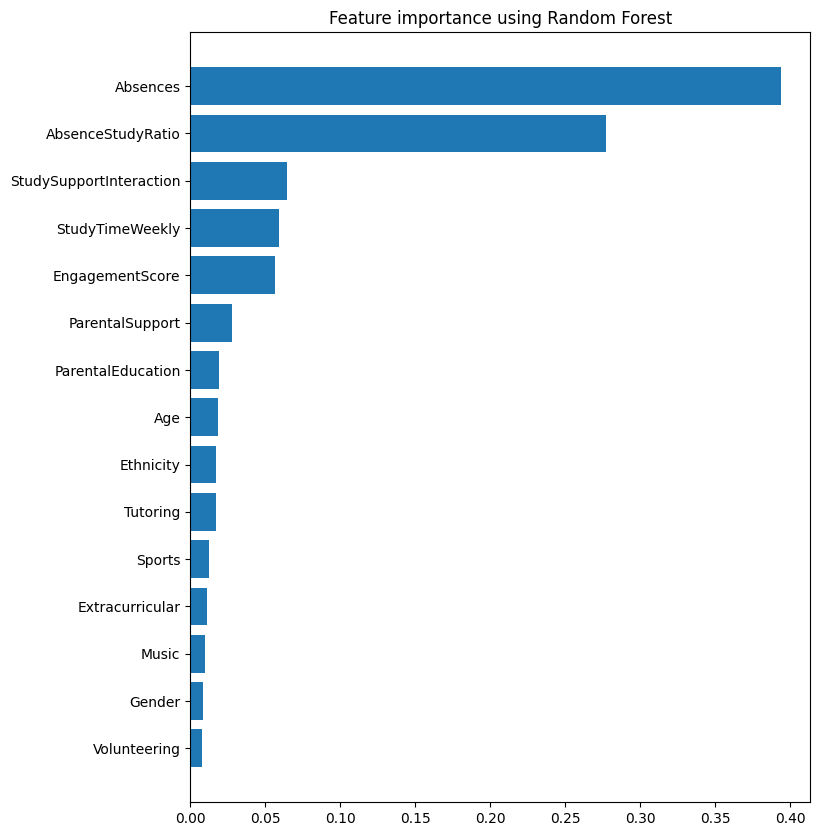

In [27]:
plt.figure(figsize=(8,10))
plt.barh(features_importance["Feature"], features_importance["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance using Random Forest")
plt.show()


**Analysis of the importance of variables**

**1. Dominant variables**

- Absences: 0.3935

This is by far the most influential variable for predicting GradeClass.
This confirms what we had already observed: attendance is the most predictive factor of academic success.
The more a student is absent, the more likely they are to be in category C and the less likely they are to be in category A.

- AbsenceStudyRatio: 0.2769

This derived feature combines absences + study time, giving the model a view of actual engagement.

**2. Secondary (but useful) variables**

- StudySupportInteraction: 0.0641

Indicates that study time combined with parental support has a significant impact.
Students who work hard and are supported by their parents perform better.

- StudyTimeWeekly: 0.0591

Personal work remains an important factor, but less so than absences.

- EngagementScore: 0.0568

This feature measures the student's overall activity. Overall engagement seems to correlate with success, but only moderately.

**3. Tertiary variables (low impact)**

Importance between 1% and 3%:
- ParentalSupport (2.8%)
- ParentalEducation (1.9%)
- Age, Tutoring, Ethnicity (1.7–1.8%)
- Sports, Extracurricular, Music (1%)

These factors play a role, but a minor one compared to absences.

This means that **direct school behavior (attendance + work)** largely dominates socio-cultural factors or extracurricular activities.




### Comparison of different models

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#split the dataset into X and y=target
y = df["GradeClass"]
X = df.drop(columns=['GPA','GradeClass'])

#train-test split
X_train,X_test, y_train,y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y)

models={
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",  #active multiclass classification and returns probabilities
        num_class=3,                 #nb of classes to predict
        eval_metric="mlogloss",      #measures the quality of predicted probabilities
        tree_method="hist",          #fast and optimized method for constructing trees
        random_state=42,
        enable_categorical=False)}

#Scaling: required for kNN, SVM, and LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Training+Evaluation
results=[]

for name, model in models.items():
    model.fit(X_train_scaled,y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test,preds)
    results.append([name, acc])

    print("\n----------------")
    print(name)
    print("----------------")
    print("Accuracy:", acc)
    print("Report:")
    print(classification_report(y_test,preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test,preds))

#Visualization
df_results=pd.DataFrame(results, columns=["Model", "Accuracy"])
df_results=df_results.sort_values("Accuracy", ascending=False)
print("\n--- Final results ---")
print(df_results)


----------------
Random Forest
----------------
Accuracy: 0.8768267223382046
Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        64
           1       0.79      0.86      0.82       160
           2       0.94      0.92      0.93       255

    accuracy                           0.88       479
   macro avg       0.86      0.84      0.85       479
weighted avg       0.88      0.88      0.88       479

Confusion Matrix:
[[ 48  16   0]
 [  8 137  15]
 [  0  20 235]]

----------------
Gradient Boosting
----------------
Accuracy: 0.8851774530271399
Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        64
           1       0.81      0.86      0.83       160
           2       0.94      0.93      0.93       255

    accuracy                           0.89       479
   macro avg       0.87      0.86      0.86       479
weighted avg       0.89      0.89      0.89       479

**Analysis of GradeClass prediction results**

We can see that the four best models are:
- Logistic Regression: 0.891441
- SVM:  0.887265
- Gradient Boosting:  0.885177
- XGBoost:  0.878914

Therefore, for further analysis and hyperparameter tuning, we will no longer consider Random Forest and k-Nearest Neighbors.

For **Logistic Regression:**
1. Overall performance
- Accuracy = 89%, indicating that the model makes good predictions
- Average F1-score = 0.89, confirming good performance even when taking class imbalance into account.
- Logistic regression therefore performs very well for a linear model, implying that the separation between classes is relatively linear.

2. Analysis by class:

**Class 0 (A):**
- Precision: 0.88, Recall: 0.80
- The model identifies the majority but still misses several, often confused with class 1 (B).
- This class is difficult to distinguish because it is less represented and close to the middle class.

**Class 1 (B):**
- Precision: 0.82, Recall: 0.86
- Performance is acceptable, but the class is sometimes confused with 0 and especially with 2.
- Intermediate class, often the most ambiguous.

**Class 2 (C):**
- Precision: 0.94, Recall: 0.93
- Very good recognition: the model clearly distinguishes weak students.
- Dominant class, therefore easier to separate.


For **SVM:**
1. Overall performance
- Accuracy: 88.7%, very close to logistic regression
- Average F1 score: 0.89, indicating good overall performance

2. Analysis by class

**Class 0 (A)**
- Low recall (0.72): the model misses quite a few A students
- Frequent confusion with class 1 (B)

**Class 1 (B)**
- Good detection (recall 0.88).
- Some confusion with A and C, which is normal for an intermediate class.

**Class 2 (C)**
- Very good performance (precision 0.94/recall 0.93).
- Dominant class, therefore well mastered by the model.


For **Gradient Boosting:**

- Accuracy: 0.885

Main scores:
- Class 0: good precision (0.88), correct recall (0.78)
- Class 1: precision 0.81, recall 0.86
- Class 2: very good performance (precision 0.94, recall 0.93)


For **XGBoost:**

- Accuracy: 0.879

Main scores:
- Class 0: precision 0.86, recall 0.75
- Class 1: precision 0.79, recall 0.86
- Class 2: very good scores (0.94/0.92)

**Conclusion:**

Thanks to its slightly superior performance and greater consistency across classes, **logistic regression** is the best model according to classification metrics.

### Overfitting/underfitting risk analysis

In [29]:
overfit_results=[]

print("Overfitting/Underfitting check")

for name,model in models.items():
    #Train prediction
    train_pred=model.predict(X_train_scaled) #model predicts based on the data it was trained on
    train_acc=accuracy_score(y_train,train_pred)

    #Test prediction
    test_pred=model.predict(X_test_scaled) #model predicts on new data that it has never seen before
    test_acc=accuracy_score(y_test,test_pred)

    #Difference
    diff=train_acc-test_acc

    overfit_results.append([name, train_acc,test_acc,diff])

    print(f"\n{name}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Difference: {diff:.4f}")

df_overfit = pd.DataFrame(overfit_results,
                          columns=["Model", "Train Accuracy", "Test Accuracy", "Difference"])
display(df_overfit)


Overfitting/Underfitting check

Random Forest
Train Accuracy: 1.0000
Test Accuracy: 0.8768
Difference: 0.1232

Gradient Boosting
Train Accuracy: 0.9561
Test Accuracy: 0.8852
Difference: 0.0709

SVM
Train Accuracy: 0.9435
Test Accuracy: 0.8873
Difference: 0.0563

K-Nearest Neighbors
Train Accuracy: 0.8385
Test Accuracy: 0.7349
Difference: 0.1036

Logistic Regression
Train Accuracy: 0.9106
Test Accuracy: 0.8914
Difference: 0.0192

XGBoost
Train Accuracy: 1.0000
Test Accuracy: 0.8789
Difference: 0.1211


,Model,Train Accuracy,Test Accuracy,Difference
0,Random Forest,1.000000,0.876827,0.123173
1,Gradient Boosting,0.956090,0.885177,0.070912
2,SVM,0.943544,0.887265,0.056279
3,K-Nearest Neighbors,0.838474,0.734864,0.103609
4,Logistic Regression,0.910612,0.891441,0.019171
5,XGBoost,1.000000,0.878914,0.121086


**Analysis:**

**1. Logistic Regression:**
- Difference: 0.019
- No overfitting because training is approximately equal to testing

**2. Gradient Boosting**
- Difference: 0.071
- Generalizes correctly
- No significant overfitting

**3. SVM**
- Difference: 0.056
- Slight overfitting but normal and acceptable for SVM

**4. Random Forest**
- Difference: 0.123
- Significant overfitting, the model does not generalize very well

**5. XGBoost**
- Difference: 0.121
- Significant overfitting like Random Forest

**6. KNN**
- Difference: 0.104
- Low train accuracy, therefore underfitting
- Significant gap, therefore some overfitting

Therefore, we will only consider **Logistic Regression, Gradient Boosting, SVM, and Random Forest**, which we can rework with hyperparameter tuning.



### Model’s hyperparameter’s tuning

  Logistic Regression  0.891441
2                  SVM  0.887265
1    Gradient Boosting  0.885177
5              XGBoost  0.878914

- **XGBoost Hyperparameter Tuning**

In [40]:
from sklearn.model_selection import RandomizedSearchCV

#pipeline
#no need of scaling for XGBoost
pipeline = Pipeline([
    ("model", XGBClassifier(objective="multi:softprob",num_class=3))
])

#hyperparameters search space
param_search_xgb={
    "model__n_estimators": [100, 200, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7, 10],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}

#randomized search
search_xgb=RandomizedSearchCV(
    pipeline,
    param_distributions=param_search_xgb,
    cv=5,
    n_iter=20,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)
search_xgb.fit(X_train,y_train)

print("Best parameters:", search_xgb.best_params_)
print("Best score:", search_xgb.best_score_)

Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
Best score: 0.8923243065902969


**XGBoost after hyperparameter tuning (RandomizedSearchCV):**

We obtained the best parameters:  
- 'model__subsample': 0.8
- 'model__n_estimators': 300
- 'model__max_depth': 3
- 'model__learning_rate': 0.05
- 'model__colsample_bytree': 0.7

And finally, we have **Best score (CV): 0.8923**.

'model__max_depth': 3 reduces complexity and therefore overfitting.

After hyperparameter optimization, the model shows improved performance and better generalization ability. The model is now better tuned, more stable, and more efficient than its default version.

**Why RandomizedSearchCV?**
- because it is much faster than GridSearch
- it explores the hyperparameter space sufficiently well
- it is very well suited to models such as XGBoost, which are slow to train.




- **Gradient Boosting Hyperparameter Tuning**

In [39]:
#pipeline
#no need of scaling for GradientBoosting
pipeline = Pipeline([
    ("model", GradientBoostingClassifier(random_state=42))
])

#hyperparameters search space
param_search_gradboost = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3],
    "model__subsample": [0.8, 1.0]
}

#randomized search
search_gradboost = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_search_gradboost,
    n_iter=10,          #number of random combinations
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)
search_gradboost.fit(X_train,y_train)

print("Best parameters:", search_gradboost.best_params_)
print("Best cross-val score:", search_gradboost.best_score_)

Best parameters: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 2, 'model__learning_rate': 0.1}
Best cross-val score: 0.8902327997484722


**GradientBoosting after hyperparameter tuning (RandomizedSearchCV):**

We obtained the best parameters:  
- 'model__subsample': 1
- 'model__n_estimators': 200
- 'model__max_depth': 2
- 'model__learning_rate': 0.1

And the best cross-validation score is: **0.8902**.

These hyperparameters suggest a model that is more regularized and less complex, especially with:
- max_depth=2

This reduces the depth of the trees, lowering model complexity and helping prevent overfitting.

- subsample=1.0 + learning_rate=0.1

The model learns faster while keeping enough randomness to stabilize training.

Overall, after hyperparameter optimization, the Gradient Boosting model becomes more stable, more consistent and better tuned compared to the default version. It generalizes slightly better while maintaining strong predictive performance.

**Why RandomizedSearchCV?**
- because it is much faster than GridSearch
- it explores the hyperparameter space sufficiently well
- it is very well suited to models such as GradientBoosting, which are slow to train.

- **SVM Hyperparameter Tuning**

In [38]:
from sklearn.model_selection import GridSearchCV

pipeline=Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])
param_grid_svm={
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf", "poly"]
}
grid_svm=GridSearchCV(
    pipeline,
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_svm.fit(X_train,y_train)

print("Best parameters:", grid_svm.best_params_)
print("Best score:", grid_svm.best_score_)


Best parameters: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best score: 0.8787295121184368


**SVM after hyperparameter tuning (GridSearchCV):**

We obtained the best parameters:  
- 'model__C': 1
- 'model__gamma': 'scale'
- 'model__kernel': 'rbf'

And the best cross-validation score is: **0.8787**.

These hyperparameters indicate that the SVM converges toward a relatively balanced configuration:
- C = 1

This effectively balances margin width and training errors.  
A moderate value prevents the model from overfitting the noise in the dataset.

- kernel='rbf' + gamma='scale'

The **RBF** kernel allows nonlinear relationships to be captured.  
With **gamma=scale**, the decision boundary remains stable and well regularized.

Overall, after hyperparameter optimization, the SVM model becomes more stable and better calibrated.
The chosen hyperparameters lead to a model that generalizes well while avoiding excessive complexity, producing consistent and reliable performance on unseen data.

**Why GridSearchCV?**
- it thoroughly explores the hyperparameter space
- it guarantees the best combination within the search grid
- SVM models are relatively fast to train, making GridSearchCV efficient


- **Logistic Regression Hyperparameter Tuning**

In [41]:
pipeline=Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=42,max_iter=1000))
])
param_grid_logreg={
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "saga"]
}
grid_logreg=GridSearchCV(
    pipeline,
    param_grid_logreg,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_logreg.fit(X_train,y_train)

print("Best parameters:", grid_logreg.best_params_)
print("Best score:", grid_logreg.best_score_)


Best parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best score: 0.9043470534359492


**Logistic Regression after hyperparameter tuning (GridSearchCV):**

We obtained the best parameters:  
- 'model__C': 10
- 'model__penalty': 'l2'
- 'model__solver': 'lbfgs'

And the best cross-validation score is: **0.9043**, which is the highest among all models tested.

Interpretation of the hyperparameters :

**C = 1**
- A higher C reduces regularization, allowing the model to better fit the data
- the data benefits from a slightly more flexible decision boundary, improving accuracy

**penalty = L2**
- L2 regularization stabilizes the model and avoids coefficients becoming too large

**solver = lbfgs**
- Well suited for multiclass classification and efficient with L2 penalty
- More stable and faster than saga for this case

**Conclusion:**

After tuning, Logistic Regression becomes both simple and very effective, achieving the best generalization score. It balances bias and variance well, and its linear nature seems to fit the structure of the dataset exceptionally well.


### Best optimized model on our test set:

- **Logistic Regression**

In [42]:
#retrieve the best model from GridSearchCV
best_logreg = grid_logreg.best_estimator_

#predict on test set
y_pred=best_logreg.predict(X_test)

#evaluate performance
accuracy = accuracy_score(y_test,y_pred)
print("Test Accuracy:",accuracy)

print("\nClassification Report:")
print(classification_report(y_test,y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

0.891441


Test Accuracy: 0.8914405010438413

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        64
           1       0.82      0.86      0.84       160
           2       0.94      0.93      0.94       255

    accuracy                           0.89       479
   macro avg       0.88      0.86      0.87       479
weighted avg       0.89      0.89      0.89       479

Confusion Matrix:
[[ 51  13   0]
 [  7 138  15]
 [  0  17 238]]


0.891441

**Analyze of GradeClass prediction results:**

After hyperparameter tuning, Logistic Regression achieves a better score in cross-validation, but its accuracy on the test set remains the same as before tuning (0.8914). This means that tuning did not improve the model's generalization, probably because it was already well optimized from the outset.

**Why?**
- The model was already very well tuned before tuning.
- Tuning maximizes CV performance, but not necessarily that of the test set.
- Logistic Regression is a simple model, so hyperparameter tuning does not have a huge impact.




- **SVM**

In [43]:
# Best model from grid search
best_svm = grid_svm.best_estimator_

# Predictions on the test set
y_pred = best_svm.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.8872651356993737

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80        64
           1       0.80      0.88      0.84       160
           2       0.94      0.93      0.94       255

    accuracy                           0.89       479
   macro avg       0.88      0.84      0.86       479
weighted avg       0.89      0.89      0.89       479

Confusion Matrix:
[[ 46  18   0]
 [  5 141  14]
 [  0  17 238]]


**SVM after hyperparameter tuning**

In our case, tuning did not change the performance of the SVM:
the accuracy on the test set remains strictly identical to that obtained before optimization (0.8873), and the classification report and confusion matrix are unchanged.

Tuning confirmed that the performance of the SVM was already optimal.

- **Gradient Boosting**

In [44]:
#best model from RandomizedSearchCV
best_gradboost = search_gradboost.best_estimator_

#predictions
y_pred_gradboost = best_gradboost.predict(X_test)

#results
print("Test Accuracy:", accuracy_score(y_test, y_pred_gradboost))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gradboost))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gradboost))

Test Accuracy: 0.8893528183716075

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        64
           1       0.82      0.86      0.84       160
           2       0.94      0.94      0.94       255

    accuracy                           0.89       479
   macro avg       0.87      0.86      0.86       479
weighted avg       0.89      0.89      0.89       479


Confusion Matrix:
[[ 50  14   0]
 [  9 137  14]
 [  0  16 239]]


**GradientBoosting after hyperparameter tuning**

- Result before tuning: Accuracy=0.885 and F1-score=0.86
- Result after tuning: Accuracy=0.889 and F1-score=0.86

Hyperparameter tuning had only a marginal impact because:
- Gradient Boosting was already close to its optimum
- scikit-learn's default hyperparameters are robust
- the dataset is well suited to a boosted tree model, even without tuning

The variations between confusion matrices show only a few observations redistributed between classes 1 and 2, resulting in minimal changes.



- **XGBoost**

In [45]:
#best model
best_xgb = search_xgb.best_estimator_

#predictions
y_pred_xgb = best_xgb.predict(X_test)

#results
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Test Accuracy: 0.8893528183716075

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        64
           1       0.81      0.87      0.84       160
           2       0.95      0.93      0.94       255

    accuracy                           0.89       479
   macro avg       0.87      0.86      0.87       479
weighted avg       0.89      0.89      0.89       479


Confusion Matrix:
[[ 50  14   0]
 [  8 139  13]
 [  0  18 237]]


**XGBoost after hyperparameter tuning**

- Result before tuning: Accuracy=0.879 and F1-score=0.85
- Result after tuning: Accuracy=0.889 and F1-score=0.87

Tuning allows XGBoost to:
- gain stability,
- slightly improve predictions on minority classes
- obtain the best F1 score among the models tested

The improvement is moderate but real, unlike classic Gradient Boosting where the gain was almost zero.

**BEST MODEL TO PREDICT GRADECLASS:**

**Logistic Regression** is the best choice:
- displays the best accuracy on the test set (0.89144)
- presents very balanced F1 scores between the three classes (A, B, C)
- It is a simple, stable, and interpretable model, which is an advantage for analysis and action


# Test your grade!